In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# 1. Load the data
df = pd.read_csv('looks_at.csv')

print(f"Dataset loaded with shape: {df.shape}")

Dataset loaded with shape: (224503, 12)


# 2. Exploratory Data Analysis (EDA)

In [3]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224503 entries, 0 to 224502
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   person ID           224503 non-null  object
 1   country             224503 non-null  object
 2   age                 224503 non-null  int64 
 3   gender              224503 non-null  object
 4   education           224503 non-null  object
 5   visual acuity       224503 non-null  object
 6   reading speed       224503 non-null  object
 7   text density        224503 non-null  object
 8   font size           224503 non-null  object
 9   paper type          224503 non-null  object
 10  initial focus time  224503 non-null  object
 11  looks at            224503 non-null  object
dtypes: int64(1), object(11)
memory usage: 20.6+ MB


In [4]:
# Check for missing values
df.isnull().sum()

person ID             0
country               0
age                   0
gender                0
education             0
visual acuity         0
reading speed         0
text density          0
font size             0
paper type            0
initial focus time    0
looks at              0
dtype: int64

In [5]:
# Analyze target variable distribution
# Assuming 'looks at' is the target variable
df['looks at'].value_counts(normalize=True) * 100

looks at
top left      33.160804
top center    31.991109
center        29.776440
under left     3.054748
top right      2.016900
Name: proportion, dtype: float64

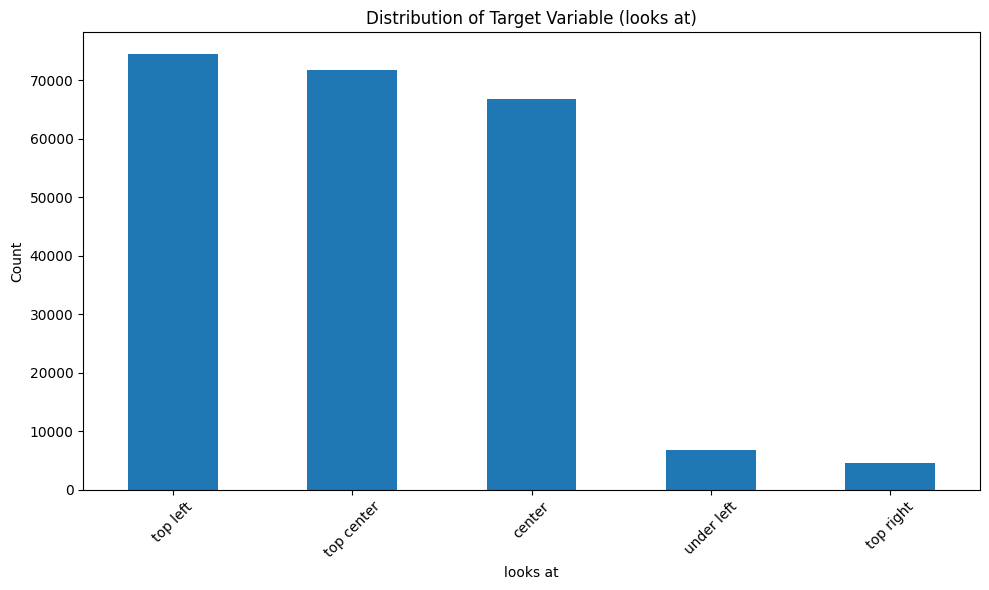

In [6]:
# Visualize target distribution
plt.figure(figsize=(10, 6))
df['looks at'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable (looks at)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('target_distribution.png')

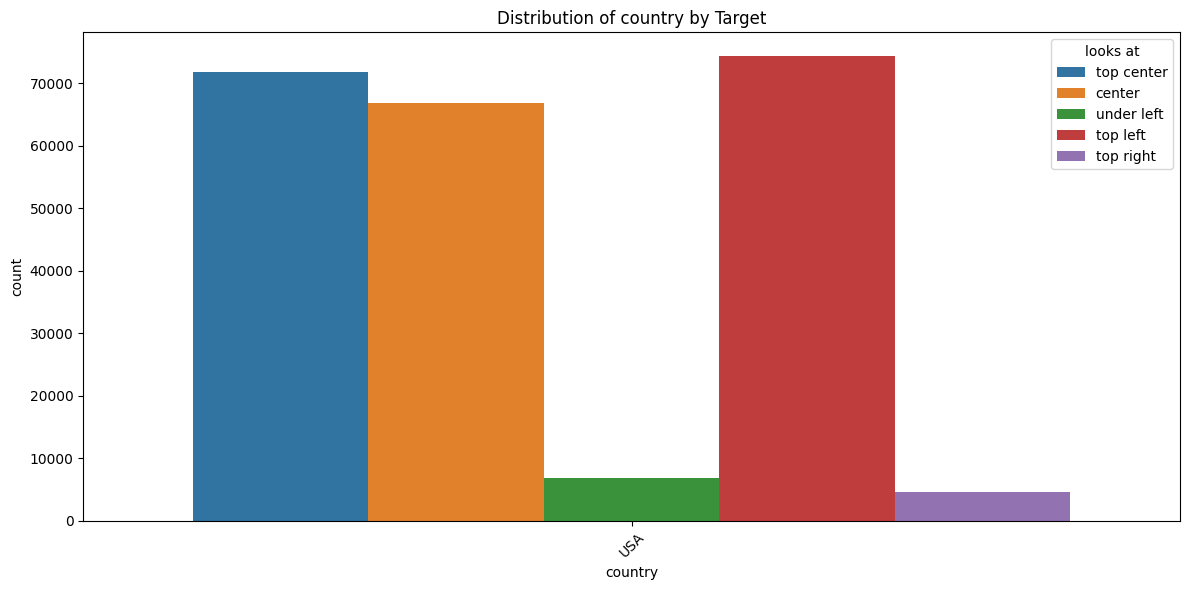

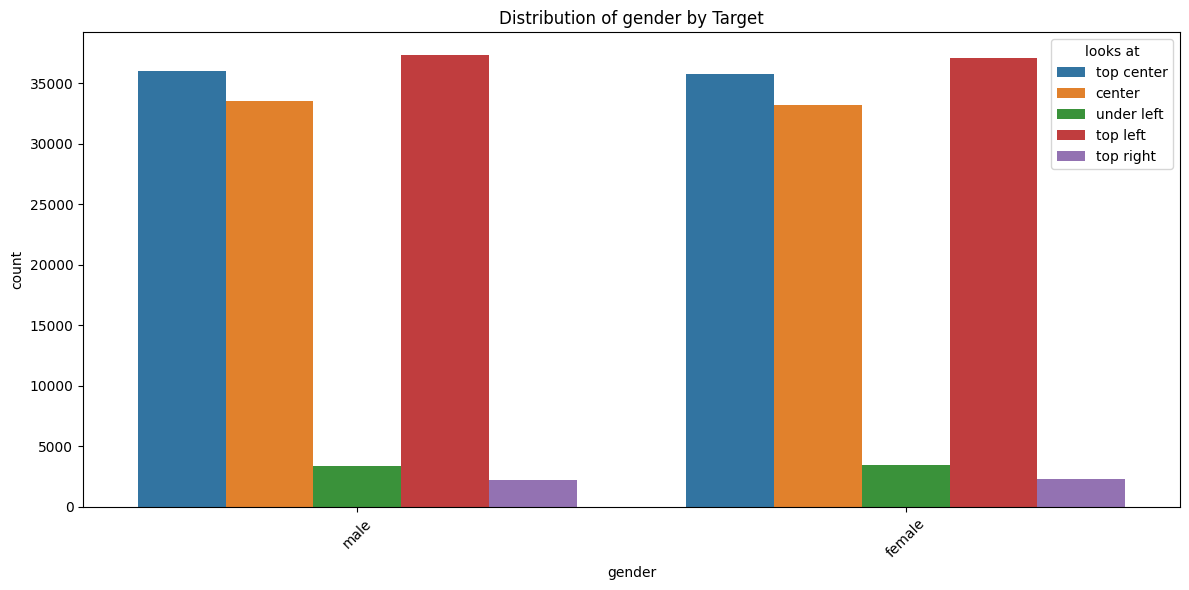

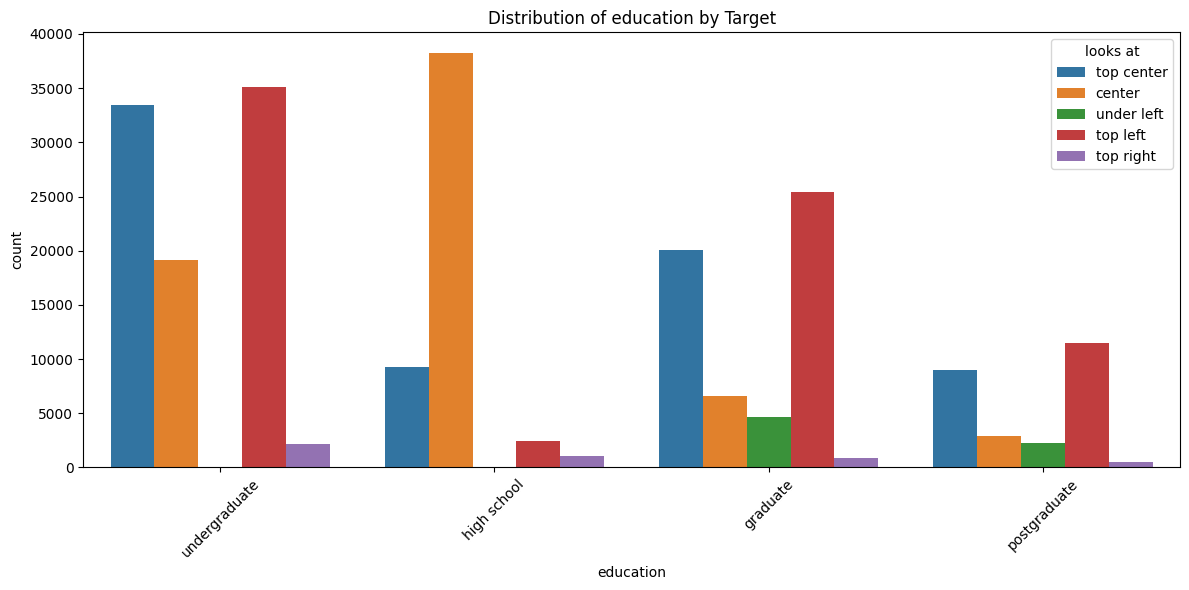

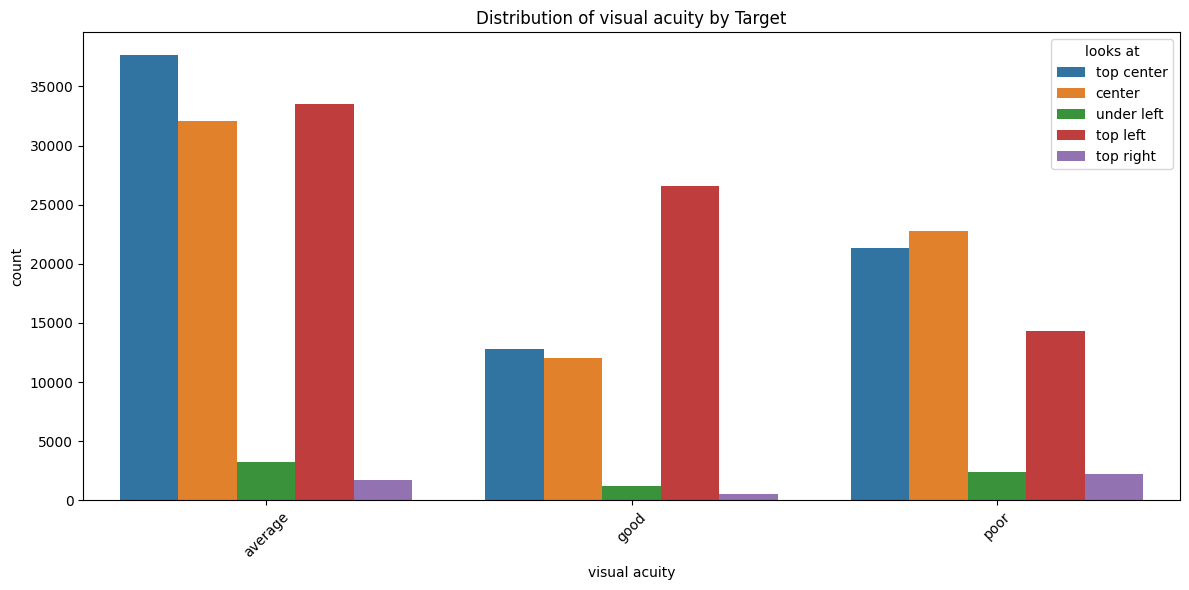

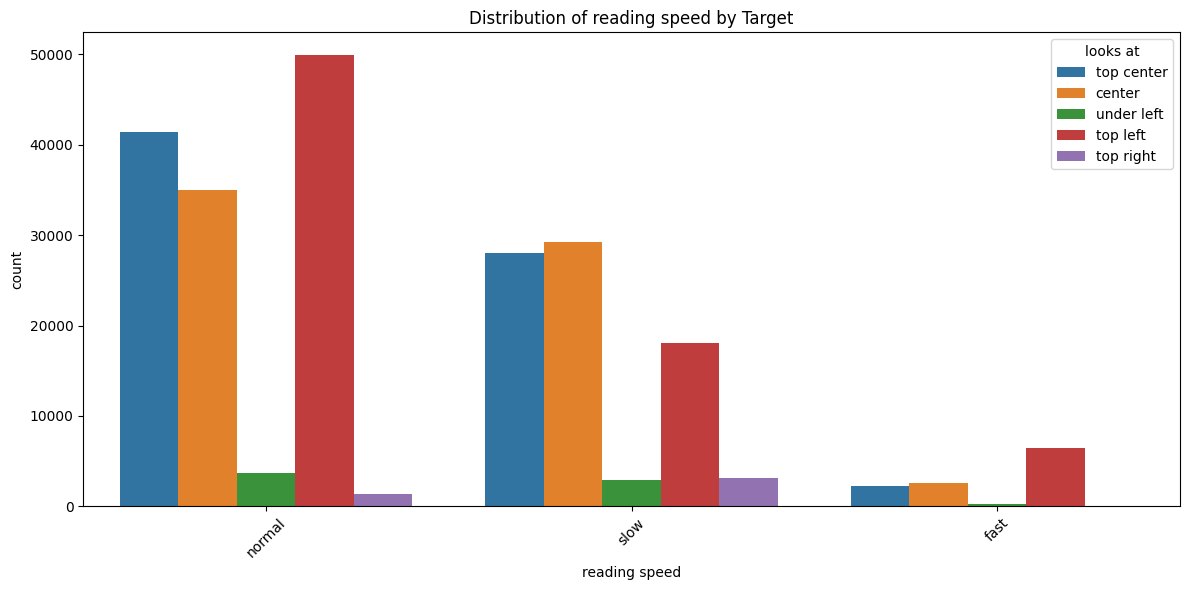

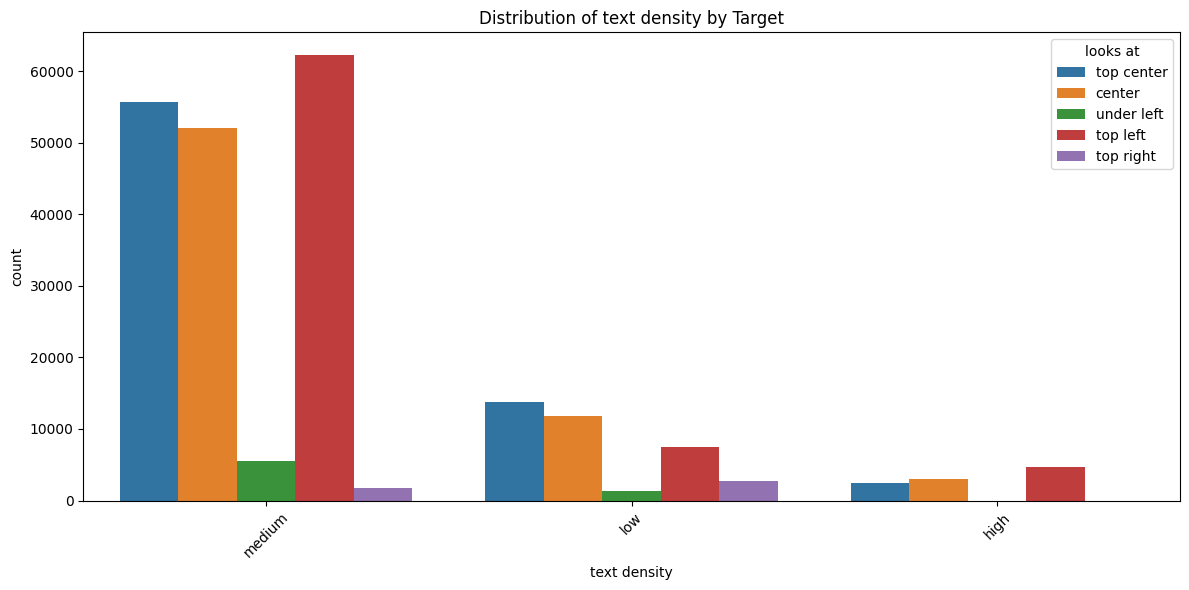

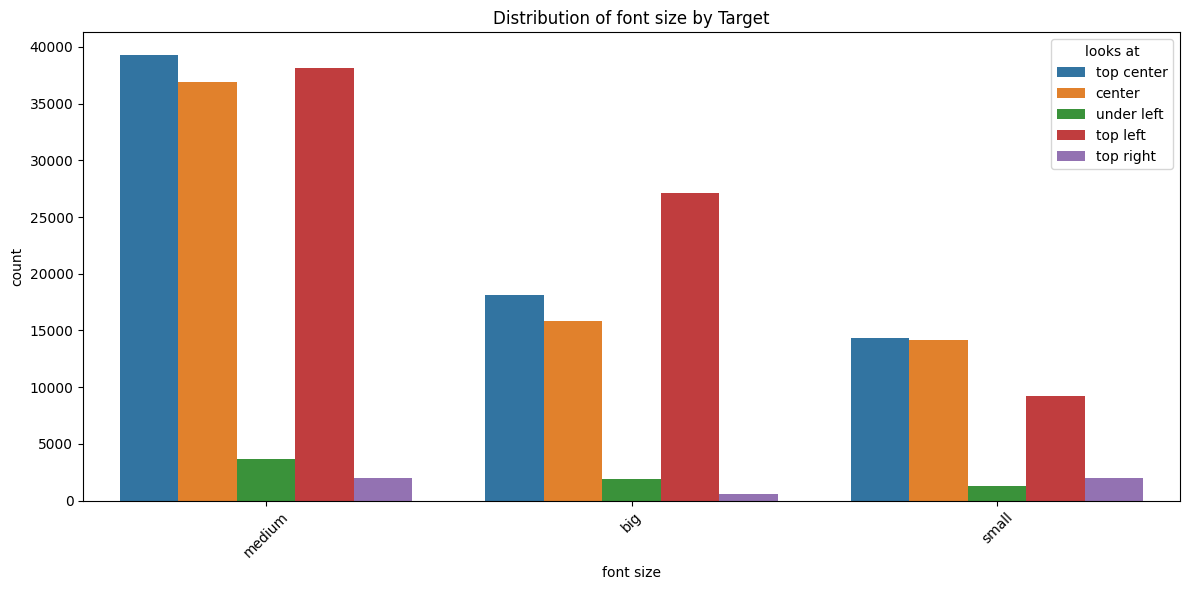

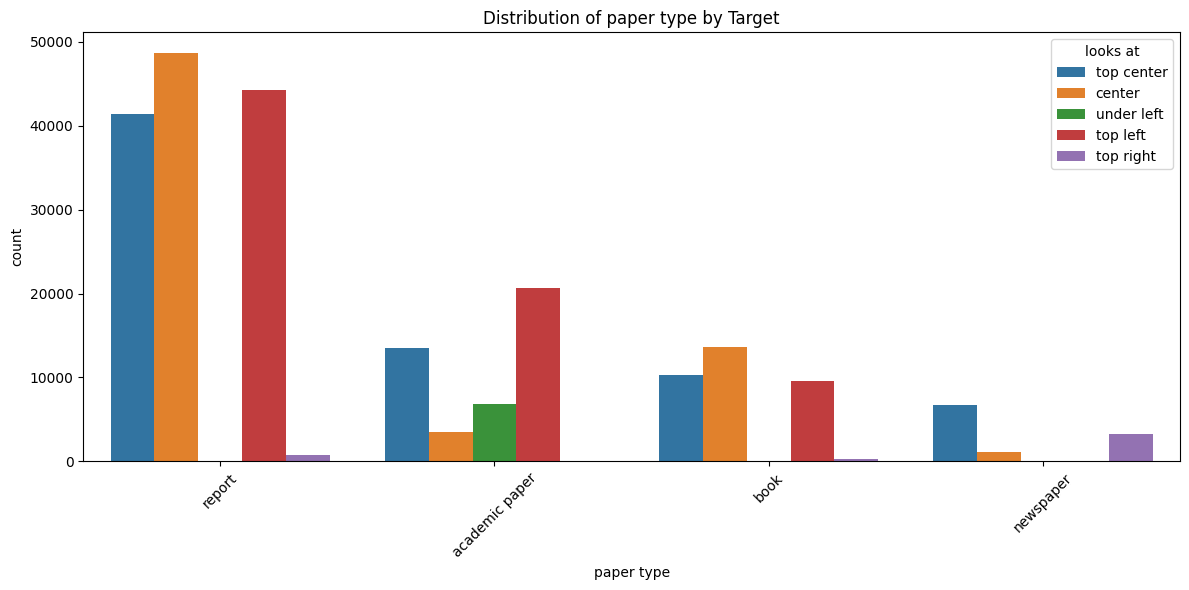

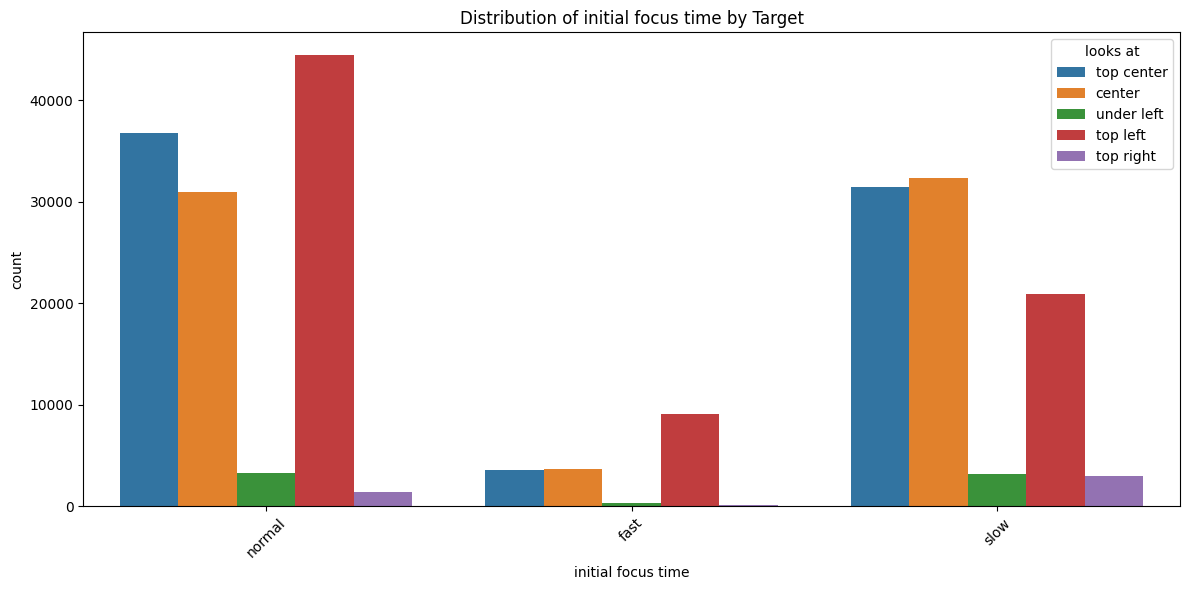

In [8]:
# Analyze the relationship between features and target
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'person ID' and col != 'looks at':
        plt.figure(figsize=(12, 6))
        sns.countplot(x=col, hue='looks at', data=df)
        plt.title(f'Distribution of {col} by Target')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'EDA/{col}_by_target.png')

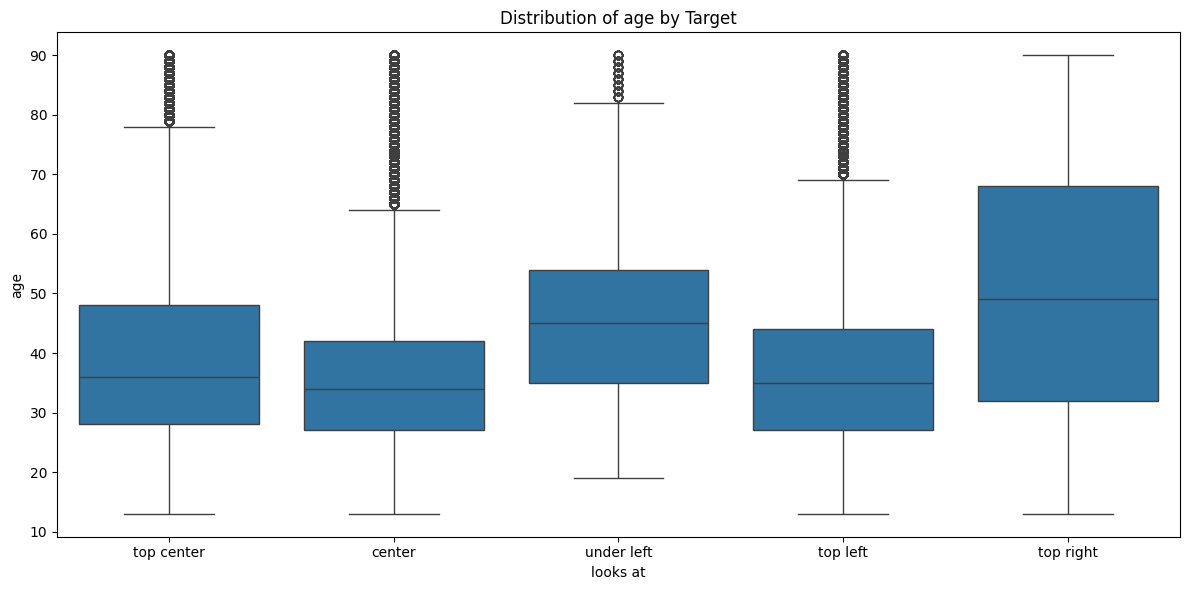

In [9]:
# Analyze numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='looks at', y=col, data=df)
    plt.title(f'Distribution of {col} by Target')
    plt.tight_layout()
    plt.savefig(f'EDA/{col}_by_target_boxplot.png')

# 3. Data Preprocessing

In [10]:
# Make a copy to avoid modifying the original data
df_processed = df.copy()

In [11]:
# Extract features and target
X = df_processed.drop(['looks at', 'person ID', 'country'], axis=1)  # Assuming 'person ID' is not a feature
y = df_processed['looks at']

In [12]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [13]:
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
# Save the label encoder for later use
joblib.dump(le, 'label_encoder.pkl')
target_classes = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Target classes mapping: {target_classes}")

Target classes mapping: {'center': np.int64(0), 'top center': np.int64(1), 'top left': np.int64(2), 'top right': np.int64(3), 'under left': np.int64(4)}


# 4. Build Model Pipeline

In [15]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [17]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [18]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [19]:
# Create the modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [20]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'education',
                                                   'visual acuity',
                                                   'reading speed',
                                                   'text density', 'font size',
                                                   'paper type',
                                                   'initial focus time'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

# 5. Train and Evaluate Model

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Define hyperparameters grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

In [23]:
# Create grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

In [24]:
# Fit the model
grid_search.fit(X_train, y_train)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [25]:
# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
    
# Print evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.6190

Classification Report:


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      center       0.71      0.77      0.74     13370
  top center       0.51      0.54      0.52     14364
    top left       0.64      0.66      0.65     14889
   top right       0.43      0.00      0.01       906
  under left       0.00      0.00      0.00      1372

    accuracy                           0.62     44901
   macro avg       0.46      0.39      0.38     44901
weighted avg       0.60      0.62      0.60     44901



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


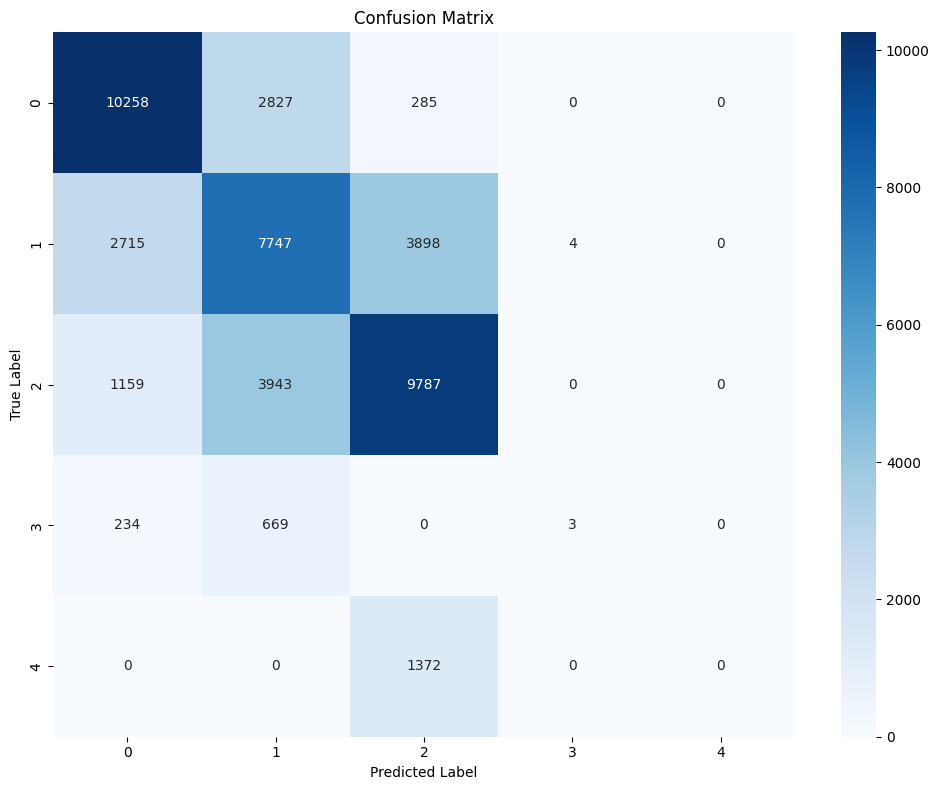

In [26]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')



In [27]:
# Save the model
joblib.dump(best_model, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'
